In [1]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version

nb_name = "02_QC_filtering.ipynb"

_compare_version(nb_name)

# 02 - QC and filtering
<hr style="border:2px solid black"> </hr>

## 1 - Description
**Quality control**

>Before analysing the single‐cell gene expression data, we must ensure that all cellular barcode data correspond to viable cells. Cell QC is commonly performed based on three QC covariates: the number of counts per barcode (count depth), the number of genes per barcode, and the fraction of counts from mitochondrial genes per barcode [...]. The distributions of these QC covariates are examined for outlier peaks that are filtered out by thresholding [...]. These outlier barcodes can correspond to dying cells, cells whose membranes are broken, or doublets. For example, barcodes with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane, and thus, only mRNA located in the mitochondria is still conserved [...]. In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

SOURCE: [10.15252/msb.20188746](https://doi.org/10.15252/msb.20188746)

_______

## 2 - Setup

In [2]:
import sctoolbox
import sctoolbox.utils as utils
import sctoolbox.tools.qc_filter as qc
import sctoolbox.tools.marker_genes as marker_genes
import sctoolbox.plotting as pl

import matplotlib.pyplot as plt
import pandas as pd

sctoolbox.settings.settings_from_config("config.yaml", key="02")

[WARNING] Log file '../logs/02_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


_________

## 3 - Load anndata
Uses the anndata object written by the previous notebook.

In [3]:
adata = utils.adata.load_h5ad("anndata_1.h5ad")

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: ../adatas/anndata_1.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'filename', 'rel_path'
    var: '1'
    uns: 'sctoolbox'

,filename,rel_path
index,,
AAACATACAACCAC-1,matrix.mtx,.
AAACATTGAGCTAC-1,matrix.mtx,.
...,...,...
TTTGCATGAGAGGC-1,matrix.mtx,.
TTTGCATGCCTCAC-1,matrix.mtx,.


,1
index,
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A
...,...
ENSG00000215616,AC002321.2
ENSG00000215611,AC002321.1


__________

## 4 - QC and filtering
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [4]:
%bgcolor PowderBlue

# Set the species of the data
species = "human"

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

# Set the column in adata.var containing gene names (or set to None to use adata.var index)
gene_column = None

# Absolute minimum number of genes for pre-selection of cells before QC plotting
min_genes = 1

# Decide whether to remove doublets using scrublet (True) or to skip doublet calculation (False)
# Set the treshold manually or "None" for automatic treshold prediction
filter_doublets = True
threads = 4
doublet_threshold = None 

# Whether to try to predicting the sex of samples using the expression of a female gene
predict_sex = True
female_gene = "Xist"  # name of the gene to use for the sex assignment

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = False

# Removal of gene subsets
filter_mito = True
filter_ribo = False
filter_gender = False

# Optional: Plot STARsolo quality if a path is given
quant_folder = ""

############# Denoise and remove ambient RNA #############
#!!This process takes a long time depending on the size of the dataset!!
#Removing ambient RNA and denoising data using scAR
#You need the raw anndata containing the raw matrix with all drpolets
path_raw_adata = "../adatas/anndata_raw.h5ad"  # provide the path to the raw h5ad file
epochs = 150  # number of iterations for the model

________

In [ ]:
#Ensure that condition column is a category
adata.obs[condition_column] = adata.obs[condition_column].astype("category")

### 4.1 - Show STARsolo quality (optional)

If the data was mapped using STARsolo, use the parameter to set the path to the STARsolo runs and plot quality measures across runs. The path must be a folder, e.g. "path/to/starsolo_output", which contains folders per condition e.g. "cond1", "cond2", etc.

In [ ]:
if quant_folder != "":
    _ = pl.qc_filter.plot_starsolo_quality(quant_folder, save="starsolo_quality.pdf")
    _ = pl.qc_filter.plot_starsolo_UMI(quant_folder, ncol=3, save="starsolo_cell_selection.pdf")

_________

### 4.2 - Label genes
Mark genes on their general association. E.g. mitochondrial.

In [ ]:
qc_vars = marker_genes.label_genes(adata, gene_column=gene_column, species=species)
qc_vars

In [ ]:
adata.obs

_________

### 4.3 - Calculate QC metrics
Create quality control metrics to filter the data on.

In [ ]:
adata = qc.calculate_qc_metrics(adata, qc_vars=qc_vars)

_________

### 4.4 - Calculate doublet scores

In [ ]:
# Set filter for number of genes before calculating doublets
n_cells_before = len(adata)
adata = adata[adata.obs["n_genes"] >= min_genes]
n_cells_after = len(adata)
print(f"Filtered out {n_cells_before-n_cells_after} cells which had less than {min_genes} gene(s) expressed.")

In [ ]:
if filter_doublets:
    
    qc.estimate_doublets(adata, groupby=condition_column, threads=threads, threshold=doublet_threshold)
    
    #Remove the duplicates from adata
    qc.filter_cells(adata, "predicted_doublet", remove_bool=True)

_________

### 4.5 - Predict sex per sample

In [ ]:
if predict_sex:
    qc.predict_sex(adata, groupby=condition_column, gene_column=gene_column, gene=female_gene, 
                   save="female_prediction.pdf")

_________

### 4.6 - Cell filtering
<hr style="border:1px solid black"> </hr>

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

In [ ]:
# Choose columns to be used for filtering
obs_columns = ["n_genes", "log1p_total_counts"]
obs_columns += ["pct_counts_" + var for var in qc_vars if var != "is_gender"]

utils.adata.add_uns_info(adata, "obs_metrics", obs_columns, how="append")
obs_columns

#### 4.6.1 - Estimate initial thresholds automatically

In [ ]:
groupby = condition_column if global_threshold is False else None
initial_thresholds = qc.automatic_thresholds(adata, which="obs", groupby=groupby, columns=obs_columns)
qc.thresholds_as_table(initial_thresholds) # show thresholds

#### 4.6.2 - Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [ ]:
%matplotlib widget

# Plot violins and sliders
obs_figure, obs_slider_dict = pl.qc_filter.quality_violin(
    adata,
    obs_columns,
    groupby=condition_column,
    which="obs",
    thresholds=initial_thresholds,
    global_threshold=global_threshold,
    title="Cell quality control (before)",
    save="cell_filtering.png"
)
obs_figure

In [ ]:
# Get final thresholds
final_thresholds = pl.qc_filter.get_slider_thresholds(obs_slider_dict)
qc.thresholds_as_table(final_thresholds) # show thresholds

In [ ]:
# Show pairwise comparisons of column values w/ thresholds (mean values in case thresholds are grouped)
%matplotlib inline
plt.close()  # close previous figure
if len(final_thresholds) > 1:
    mean_thresholds = qc.get_mean_thresholds(final_thresholds)
    _ = pl.general.pairwise_scatter(adata.obs, obs_columns, thresholds=mean_thresholds, save="cell_filtering_scatter.pdf")

#### 4.6.3 - Apply final thresholds
Filter the anndata object based on the thresholds in the threshold table.

In [ ]:
qc.apply_qc_thresholds(adata, which="obs", thresholds=final_thresholds, groupby=groupby)

#### 4.6.4 - Show data after filtering

In [ ]:
%matplotlib inline 

# Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    obs_columns,
    groupby=condition_column,
    which="obs", ncols=3,
    global_threshold = global_threshold,
    title="Cell quality control (after)",
    save="cell_filtering_final.png"
)
figure

_________

### 4.7 - Gene filtering
<hr style="border:1px solid black"> </hr>

In [ ]:
#Recalculate quality measures for genes
adata = qc.calculate_qc_metrics(adata)

In [ ]:
#Remove genes with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
%bgcolor PowderBlue

#Choose columns for quality control
var_columns = ["n_cells_by_counts", "log1p_mean_counts"]

____________

#### 4.7.1 - Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [ ]:
%matplotlib widget

# Plot violins and sliders
var_figure, var_slider_dict = pl.qc_filter.quality_violin(
    adata,
    var_columns,
    which="var",
    title="Gene quality control (before)",
    save="gene_filtering.png"
)
var_figure

#### 4.7.2 - Apply gene filtering

In [ ]:
# Get final thresholds
final_thresholds = pl.qc_filter.get_slider_thresholds(var_slider_dict)
qc.thresholds_as_table(final_thresholds) # show thresholds

In [ ]:
qc.apply_qc_thresholds(adata, which="var", thresholds=final_thresholds)

#### 4.7.3 - Show data after filtering

In [ ]:
%matplotlib inline 

# Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    var_columns,
    which="var", ncols=3,
    title="Gene quality control (after)",
    save="gene_filtering_final.png"
)
figure

#### 4.7.4 - Filter additional marked genes
Remove genes that are labeled as e.g. mitochondrial genes.

In [ ]:
# Remove mitochrondrial genes
if filter_mito is True:
    print("Removing mitochrondrial genes:")
    qc.filter_genes(adata, "is_mito")

# Remove ribosomal genes
if filter_ribo is True:
    print("Removing ribosomal genes:")
    qc.filter_genes(adata, "is_ribo")

# Remove gender genes
if filter_gender is True:
    print("Removing gender genes:")
    qc.filter_genes(adata, "is_gender")

_________

### 4.8 - Denoising
Remove ambient RNA and technical noise from the count matrix using scAR. The tool estimates the ambient profile by averaging cell-free droplets then uses an autoencoder neural network to correct the count matrix
<hr style="border:1px solid black"> </hr>

Loading raw anndata...
Denoising data, this will take a while...
[INFO] Setting up adata...
[INFO] Finisihed setting up data in: 1.37 minutes
[INFO] Training model to remove ambient RNA...


2024-07-17 16:33:31|INFO|model|No GPU detected. Use CPU instead.
2024-07-17 16:33:31|INFO|model|Found ambient profile in AnnData.uns['ambient_profile_all']
2024-07-17 16:33:34|INFO|model|kld_weight: 1.00e-05
2024-07-17 16:33:34|INFO|model|learning rate: 1.00e-03
2024-07-17 16:33:34|INFO|model|lr_step_size: 5
2024-07-17 16:33:34|INFO|model|lr_gamma: 0.97


Training: 100%|██████████| 1/1 [00:29<00:00, 29.87s/it, Loss=3.9826e+03]


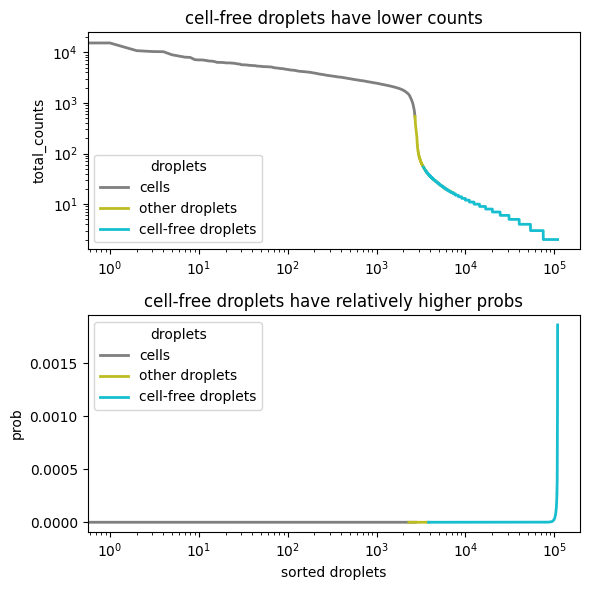

In [5]:
import scanpy as sc

if path_raw_adata:
    print("Loading raw anndata...")
    adata_raw = sc.read_h5ad(path_raw_adata)
    print("Denoising data, this will take a while...")
    adata = qc.denoise_data(adata, adata_raw, feature_type='Gene Expression', epochs=epochs,
                            verbose=False, save='droplets_kneeplot.pdf')

_________

## 5 - Save filtered adata
Store the final results

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'filename', 'rel_path'
    var: '1', 'feature_types'
    uns: 'sctoolbox', 'ambient_profile_Gene Expression', 'ambient_profile_all'

In [7]:
#Saving the data
adata_output = "anndata_2.h5ad"
utils.adata.save_h5ad(adata, adata_output)

[INFO] The adata object was saved to: ../adatas/anndata_2.h5ad


In [8]:
sctoolbox.settings.close_logfile()